In [31]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from matplotlib import pyplot
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.config.list_physical_devices('GPU')

In [2]:
# A function to return a CNN model based on input hyperparameters
def createCNN(n_filters, filter_size, n_dense, num_conv_layers, input_shape, activation, n_output, filter_size_decay = 1, dropout_conv = 0.0, dropout_dense = 0.0, batch_normalize = False, data_augment = False):
    model = models.Sequential()
    
    if data_augment:
        data_augmentation = tf.keras.Sequential([ 
                            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                            layers.experimental.preprocessing.RandomRotation(0.2)])
        model.add(data_augmentation)
    
    
    for ii in range(0, num_conv_layers): # Number of convolutional layers is num_conv_layers
        if ii == 0:
            if batch_normalize:
                model.add(layers.BatchNormalization(input_shape=input_shape))
            model.add(layers.Conv2D(n_filters, (filter_size, filter_size), activation=activation, input_shape=input_shape))
        else:
            if batch_normalize:
                model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(n_filters, (filter_size, filter_size), activation=activation))
        model.add(layers.MaxPooling2D((2, 2)))
        if dropout_conv != 0.0:
            model.add(layers.Dropout(dropout_conv))
    
        n_filters = int(n_filters * filter_size_decay)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(n_dense, activation=activation))
    if dropout_dense != 0.0:
        model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(n_output))
    
    return model

In [ ]:
dataset_path = "../../nature_12K/inaturalist_12K"
train_path = dataset_path + "/train"
test_path = dataset_path + "/val"

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

max_shape = (32, 32, 3)

data_train = ImageDataGenerator(validation_split = 0.1)

data_test = ImageDataGenerator()

train_generator = data_train.flow(
        train_images,
        train_labels,
        subset = 'training')

validation_generator = data_train.flow(
        train_images,
        train_labels,
        subset = 'validation')

test_generator = data_train.flow(
        test_images,
        test_labels)

In [ ]:
my_model = my_cnn(16, 3, 64, (32, 32, 3), 'relu', 10)
my_model.summary()

In [3]:
dataset_path = "../../nature_12K/inaturalist_12K"
train_path = dataset_path + "/train"
test_path = dataset_path + "/val"
max_shape = (256, 256, 3)

data_train = ImageDataGenerator(validation_split = 0.1)#, rescale = 1. / 255)

data_test = ImageDataGenerator()#rescale = 1. / 255)

full_train_generator = ImageDataGenerator().flow_from_directory(
        train_path,
        class_mode='categorical')

train_generator = data_train.flow_from_directory(
        train_path,
        class_mode='categorical',
        subset = 'training')

validation_generator = data_train.flow_from_directory(
        train_path,
        class_mode='categorical',
        subset = 'validation')

test_generator = data_test.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle = False)

Found 9999 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [5]:
def train(model,
          optimizer,
          loss_fn,
          epochs=10):
    model.compile(optimizer=optimizer, loss=loss_fn, metrics = ['accuracy'])
    model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[WandbCallback()])

In [6]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    }, 'parameters' : {
              "n_filters": {'values': [32, 64]},
              "filter_size_decay" : {'values':[0.5, 1, 1.15]},
              "data_augment": {'values':[True, False]},
              "dropout" : {'values':[0.0, 0.2, 0.4]},
              "batch_normalize" : {'values':[True, False]},
              "filter_size" : {'values':[3, 5]},
              "n_dense" : {'values':[50, 100]}
        }
    }

In [7]:
sweep_id = wandb.sweep(sweep_config, entity = '0x2e4', project = 'cs6910-a2')

Create sweep with ID: edqcsllx
Sweep URL: https://wandb.ai/0x2e4/cs6910-a2/sweeps/edqcsllx


In [8]:
def run():
    default_config = {
              "n_filters": 32,
              "filter_size_decay" : 1,
              "data_augment": False,
              "dropout" : 0.0,
              "batch_normalize" : False,
              "filter_size" : 3,
              "n_dense" : 50
           }

    run = wandb.init(project='cs6910-a2', config=default_config)
    config = wandb.config

    # initialize model
    model = createCNN(n_filters = config.n_filters, filter_size = config.filter_size, n_dense = config.n_dense, num_conv_layers = 5, input_shape = max_shape, activation = 'relu', n_output = 10, filter_size_decay=config.filter_size_decay, dropout_conv = config.dropout / 3, dropout_dense = config.dropout, batch_normalize=config.batch_normalize, data_augment=config.data_augment)

    # Instantiate an optimizer to train the model.
    optimizer = tf.keras.optimizers.Nadam()
    # Instantiate a loss function.
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    train(model,
      optimizer,
      loss_fn)

In [ ]:
wandb.agent(sweep_id, run)

wandb: Agent Starting Run: 2uuzbtnw with config:
wandb: 	batch_normalize: False
wandb: 	data_augment: False
wandb: 	dropout: 0
wandb: 	filter_size: 3
wandb: 	filter_size_decay: 0.5
wandb: 	n_dense: 50
wandb: 	n_filters: 32
wandb: Currently logged in as: 0x2e4 (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 132s 469ms/step - loss: 2.3092 - accuracy: 0.0957 - val_loss: 2.3024 - val_accuracy: 0.0951
Epoch 2/10
282/282 [==============================] - 134s 476ms/step - loss: 2.3027 - accuracy: 0.1007 - val_loss: 2.3006 - val_accuracy: 0.1021
Epoch 3/10
282/282 [==============================] - 133s 472ms/step - loss: 2.3002 - accuracy: 0.1036 - val_loss: 2.2996 - val_accuracy: 0.1021
Epoch 4/10
282/282 [==============================] - 134s 474ms/step - loss: 2.2995 - accuracy: 0.1022 - val_loss: 2.3022 - val_accuracy: 0.0991
Epoch 5/10
282/282 [==============================] - 133s 470ms/step - loss: 2.3012 - accuracy: 0.0989 - val_loss: 2.3038 - val_accuracy: 0.1001
Epoch 6/10
282/282 [==============================] - 133s 473ms/step - loss: 2.3026 - accuracy: 0.0930 - val_loss: 2.3020 - val_accuracy: 0.1001
Epoch 7/10
282/282 [==============================] - 134s 476ms/step - loss: 2.3015 - accuracy: 0.0948 - val_loss: 2.3035 -

wandb: Agent Starting Run: 0wysw4xr with config:
wandb: 	batch_normalize: True
wandb: 	data_augment: True
wandb: 	dropout: 0.2
wandb: 	filter_size: 5
wandb: 	filter_size_decay: 1.15
wandb: 	n_dense: 50
wandb: 	n_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 155s 551ms/step - loss: 2.3095 - accuracy: 0.1211 - val_loss: 2.2634 - val_accuracy: 0.1502
Epoch 2/10
282/282 [==============================] - 164s 580ms/step - loss: 2.2592 - accuracy: 0.1458 - val_loss: 2.2286 - val_accuracy: 0.1592
Epoch 3/10
282/282 [==============================] - 182s 646ms/step - loss: 2.2481 - accuracy: 0.1477 - val_loss: 2.2270 - val_accuracy: 0.1592
Epoch 4/10
282/282 [==============================] - 183s 650ms/step - loss: 2.2467 - accuracy: 0.1469 - val_loss: 2.2271 - val_accuracy: 0.1491
Epoch 5/10
282/282 [==============================] - 201s 711ms/step - loss: 2.2410 - accuracy: 0.1462 - val_loss: 2.2381 - val_accuracy: 0.1632
Epoch 6/10
282/282 [==============================] - 182s 644ms/step - loss: 2.2414 - accuracy: 0.1482 - val_loss: 2.2070 - val_accuracy: 0.1672
Epoch 7/10
282/282 [==============================] - 203s 720ms/step - loss: 2.2374 - accuracy: 0.1484 - val_loss: 2.2146 -

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cm6atbgh with config:
wandb: 	batch_normalize: False
wandb: 	data_augment: True
wandb: 	dropout: 0.2
wandb: 	filter_size: 3
wandb: 	filter_size_decay: 1.15
wandb: 	n_dense: 100
wandb: 	n_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 156s 552ms/step - loss: 2.8868 - accuracy: 0.1226 - val_loss: 2.2974 - val_accuracy: 0.1221
Epoch 2/10
282/282 [==============================] - 163s 577ms/step - loss: 2.2468 - accuracy: 0.1591 - val_loss: 2.2415 - val_accuracy: 0.1692
Epoch 3/10
282/282 [==============================] - 158s 561ms/step - loss: 2.2025 - accuracy: 0.1869 - val_loss: 2.1840 - val_accuracy: 0.2162
Epoch 4/10
282/282 [==============================] - 159s 564ms/step - loss: 2.1377 - accuracy: 0.2179 - val_loss: 2.1050 - val_accuracy: 0.2302
Epoch 5/10
282/282 [==============================] - 160s 567ms/step - loss: 2.1303 - accuracy: 0.2349 - val_loss: 2.1779 - val_accuracy: 0.2012
Epoch 6/10
282/282 [==============================] - 159s 563ms/step - loss: 2.1298 - accuracy: 0.2212 - val_loss: 2.1585 - val_accuracy: 0.2272
Epoch 7/10
282/282 [==============================] - 158s 561ms/step - loss: 2.0657 - accuracy: 0.2597 - val_loss: 2.1070 -

wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: i87kejot with config:
wandb: 	batch_normalize: False
wandb: 	data_augment: True
wandb: 	dropout: 0.2
wandb: 	filter_size: 5
wandb: 	filter_size_decay: 1
wandb: 	n_dense: 100
wandb: 	n_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 151s 537ms/step - loss: 2.8641 - accuracy: 0.1273 - val_loss: 2.2803 - val_accuracy: 0.1622
Epoch 2/10
282/282 [==============================] - 157s 556ms/step - loss: 2.2371 - accuracy: 0.1716 - val_loss: 2.2349 - val_accuracy: 0.1692
Epoch 3/10
282/282 [==============================] - 159s 565ms/step - loss: 2.2859 - accuracy: 0.1762 - val_loss: 2.3086 - val_accuracy: 0.1001
Epoch 4/10
282/282 [==============================] - 158s 562ms/step - loss: 2.2893 - accuracy: 0.1198 - val_loss: 2.2690 - val_accuracy: 0.1111
Epoch 5/10
282/282 [==============================] - 161s 569ms/step - loss: 2.2469 - accuracy: 0.1529 - val_loss: 2.2226 - val_accuracy: 0.2022
Epoch 6/10
282/282 [==============================] - 160s 569ms/step - loss: 2.4022 - accuracy: 0.1644 - val_loss: 2.2354 - val_accuracy: 0.1552
Epoch 7/10
282/282 [==============================] - 160s 567ms/step - loss: 2.2117 - accuracy: 0.1889 - val_loss: 2.1945 -

wandb: Agent Starting Run: uwim2q4i with config:
wandb: 	batch_normalize: False
wandb: 	data_augment: False
wandb: 	dropout: 0.4
wandb: 	filter_size: 3
wandb: 	filter_size_decay: 1.15
wandb: 	n_dense: 100
wandb: 	n_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 156s 553ms/step - loss: 3.2680 - accuracy: 0.1033 - val_loss: 2.3035 - val_accuracy: 0.1001
Epoch 2/10
282/282 [==============================] - 157s 555ms/step - loss: 2.3045 - accuracy: 0.1004 - val_loss: 2.3020 - val_accuracy: 0.1011
Epoch 3/10
282/282 [==============================] - 158s 561ms/step - loss: 2.3039 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.1041
Epoch 4/10
282/282 [==============================] - 156s 554ms/step - loss: 2.3081 - accuracy: 0.0961 - val_loss: 2.3025 - val_accuracy: 0.0971
Epoch 5/10
282/282 [==============================] - 156s 555ms/step - loss: 2.3032 - accuracy: 0.0954 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 6/10
282/282 [==============================] - 156s 555ms/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 7/10
282/282 [==============================] - 157s 556ms/step - loss: 2.3028 - accuracy: 0.0954 - val_loss: 2.3026 -

wandb: Agent Starting Run: gzu97yo1 with config:
wandb: 	batch_normalize: False
wandb: 	data_augment: True
wandb: 	dropout: 0
wandb: 	filter_size: 3
wandb: 	filter_size_decay: 1
wandb: 	n_dense: 100
wandb: 	n_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 143s 508ms/step - loss: 2.3949 - accuracy: 0.1479 - val_loss: 2.2739 - val_accuracy: 0.1872
Epoch 2/10
282/282 [==============================] - 142s 504ms/step - loss: 2.1591 - accuracy: 0.2094 - val_loss: 2.1374 - val_accuracy: 0.2412
Epoch 3/10
282/282 [==============================] - 140s 495ms/step - loss: 2.0635 - accuracy: 0.2590 - val_loss: 2.1194 - val_accuracy: 0.2272
Epoch 4/10
282/282 [==============================] - 141s 500ms/step - loss: 2.0197 - accuracy: 0.2769 - val_loss: 2.0766 - val_accuracy: 0.2673
Epoch 5/10
282/282 [==============================] - 140s 496ms/step - loss: 1.9913 - accuracy: 0.2872 - val_loss: 2.0354 - val_accuracy: 0.2733
Epoch 6/10
282/282 [==============================] - 139s 495ms/step - loss: 1.9689 - accuracy: 0.3004 - val_loss: 2.0686 - val_accuracy: 0.2733
Epoch 7/10
282/282 [==============================] - 140s 495ms/step - loss: 1.9513 - accuracy: 0.3090 - val_loss: 2.0227 -

wandb: Agent Starting Run: g413pgdk with config:
wandb: 	batch_normalize: True
wandb: 	data_augment: False
wandb: 	dropout: 0.4
wandb: 	filter_size: 3
wandb: 	filter_size_decay: 1.15
wandb: 	n_dense: 50
wandb: 	n_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/10
282/282 [==============================] - 143s 506ms/step - loss: 2.3066 - accuracy: 0.1184 - val_loss: 2.2940 - val_accuracy: 0.1181
Epoch 2/10
282/282 [==============================] - 144s 512ms/step - loss: 2.2751 - accuracy: 0.1229 - val_loss: 2.2700 - val_accuracy: 0.1411
Epoch 3/10
282/282 [==============================] - 144s 510ms/step - loss: 2.2657 - accuracy: 0.1347 - val_loss: 2.2343 - val_accuracy: 0.1682
Epoch 4/10
282/282 [==============================] - 146s 518ms/step - loss: 2.2440 - accuracy: 0.1467 - val_loss: 2.2277 - val_accuracy: 0.1692
Epoch 5/10
282/282 [==============================] - 145s 516ms/step - loss: 2.2266 - accuracy: 0.1560 - val_loss: 2.1841 - val_accuracy: 0.1812
Epoch 6/10
282/282 [==============================] - 147s 522ms/step - loss: 2.2066 - accuracy: 0.1609 - val_loss: 2.1867 - val_accuracy: 0.1892
Epoch 7/10
282/282 [==============================] - 145s 513ms/step - loss: 2.1987 - accuracy: 0.1592 - val_loss: 2.1578 -

wandb: Network error (ConnectionError), entering retry loop. See C:\Users\R Raghu Raman\Desktop\cs6910\DeepLearning\Assignment 2\wandb\run-20210410_024705-g413pgdk\logs\debug-internal.log for full traceback.


282/282 [==============================] - 144s 511ms/step - loss: 2.1869 - accuracy: 0.1678 - val_loss: 2.1871 - val_accuracy: 0.1902
Epoch 9/10
282/282 [==============================] - 140s 495ms/step - loss: 2.1800 - accuracy: 0.1667 - val_loss: 2.1586 - val_accuracy: 0.1832
Epoch 10/10
282/282 [==============================] - 139s 492ms/step - loss: 2.1935 - accuracy: 0.1614 - val_loss: 2.1868 - val_accuracy: 0.1872


In [ ]:
import random

a = [[[0 for k in range(4)] for i in range(4)] for j in range(15)]
b = [0 for k in range(15)]

for i in range(0, 15):
    for j in range(0, 4):
        for k in range(0, 4):
            a[i][j][k] = random.randint(0, 15)
    b[i] = random.randint(1, 3)

f = open('train.txt', 'w')
f.write(str(a))
f.close()
f = open('test.txt', 'w')
f.write(str(b))
f.close()

In [ ]:
import ast

f = open('train.txt', 'r')
train_s = np.asarray(ast.literal_eval(f.read()))
print(train_s)
f.close()

f = open('test.txt', 'r')
test_s = np.asarray(ast.literal_eval(f.read()))
print(test_s)
f.close()

In [ ]:
testing_model = createCNN(10, 2, 2, 3, (32, 32, 3), 'relu', 10)
testing_model.summary()

In [ ]:
testing_model.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = testing_model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val))

In [41]:
model = createCNN(n_filters = 32, filter_size = 3, n_dense = 100, num_conv_layers = 5, input_shape = max_shape, activation = 'relu', n_output = 10)

In [42]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Nadam()
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

train(model,
  optimizer,
  loss_fn)

In [5]:
best_model = createCNN(n_filters = 32, filter_size = 3, n_dense = 100, num_conv_layers = 5, input_shape = max_shape, activation = 'relu', n_output = 10, filter_size_decay = 1.15, data_augment = True)
best_model.compile(optimizer = tf.keras.optimizers.Nadam(), loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
best_model.fit(full_train_generator, epochs=10)

Epoch 1/10
313/313 [==============================] - 166s 531ms/step - loss: 2.3407 - accuracy: 0.1676
Epoch 2/10
313/313 [==============================] - 149s 477ms/step - loss: 2.1088 - accuracy: 0.2392
Epoch 3/10
313/313 [==============================] - 148s 473ms/step - loss: 2.0418 - accuracy: 0.2654
Epoch 4/10
313/313 [==============================] - 150s 480ms/step - loss: 2.0039 - accuracy: 0.2822
Epoch 5/10
313/313 [==============================] - 152s 486ms/step - loss: 1.9792 - accuracy: 0.2934
Epoch 6/10
313/313 [==============================] - 153s 490ms/step - loss: 1.9519 - accuracy: 0.3019
Epoch 7/10
313/313 [==============================] - 156s 498ms/step - loss: 1.9291 - accuracy: 0.3136
Epoch 8/10
313/313 [==============================] - 157s 500ms/step - loss: 1.9096 - accuracy: 0.3192
Epoch 9/10
313/313 [==============================] - 155s 496ms/step - loss: 1.8918 - accuracy: 0.3339
Epoch 10/10
313/313 [==============================] - 155s 496m

In [6]:
y_pred_l = best_model.predict(test_generator)
y_pred = y_pred_l.argmax(axis=1)

In [7]:
# Printing the accuracy 
y_true = np.array([np.zeros(200) + ii for ii in range(0, 10)]).flatten()
(y_pred == y_true).sum() / 2000

0.338

In [11]:
wandb.init(project = 'cs6910-a2')
imgs = []
preds = []
for some in os.listdir(test_path):
    idx = test_generator.class_indices[some]
    new_path = test_path + "/" + some
    img_path = new_path + "/" + os.listdir(new_path)[0]
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_np = wandb.Image(np.asarray(img))
    imgs.append(img_np)
    preds.append([y_pred[200 * idx], idx])

wandb.log({'table': wandb.Table(data = preds, columns = ['predicted_class', 'true_class'])})

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 1454, in _atexit_cleanup
    self._on_finish()
  File "C:\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 1590, in _on_finish
    self.history._flush()
  File "C:\anaconda3\lib\site-packages\wandb\sdk\wandb_history.py", line 59, in _flush
    self._callback(row=self._data, step=self._step)
  File "C:\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 789, in _history_callback
    self._backend.interface.publish_history(
  File "C:\anaconda3\lib\site-packages\wandb\sdk\interface\interface.py", line 211, in publish_history
    data = data_types.history_dict_to_json(run, data, step=step)
  File "C:\anaconda3\lib\site-packages\wandb\sdk\data_types.py", line 1988, in history_dict_to_json
    payload[key] = val_to_json(run, key, val, namespace=step)
  File "C:\anaconda3\lib\site-packages\wandb\sdk\data_types.py", line 2048, in val_to_json

wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [28]:
cat_path = train_path + "/Mammalia/26b7e18a07cb0fb7576b5019c2ea1577.jpg"
cat_np = np.asarray(tf.keras.preprocessing.image.load_img(cat_path, target_size = (max_shape[0], max_shape[1])))
cat_np = np.expand_dims(cat_np, axis=0)

filter_vis = models.Sequential()
filter_vis.add(best_model.layers[1])
result = filter_vis.predict(cat_np)

(1, 254, 254, 32)

wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


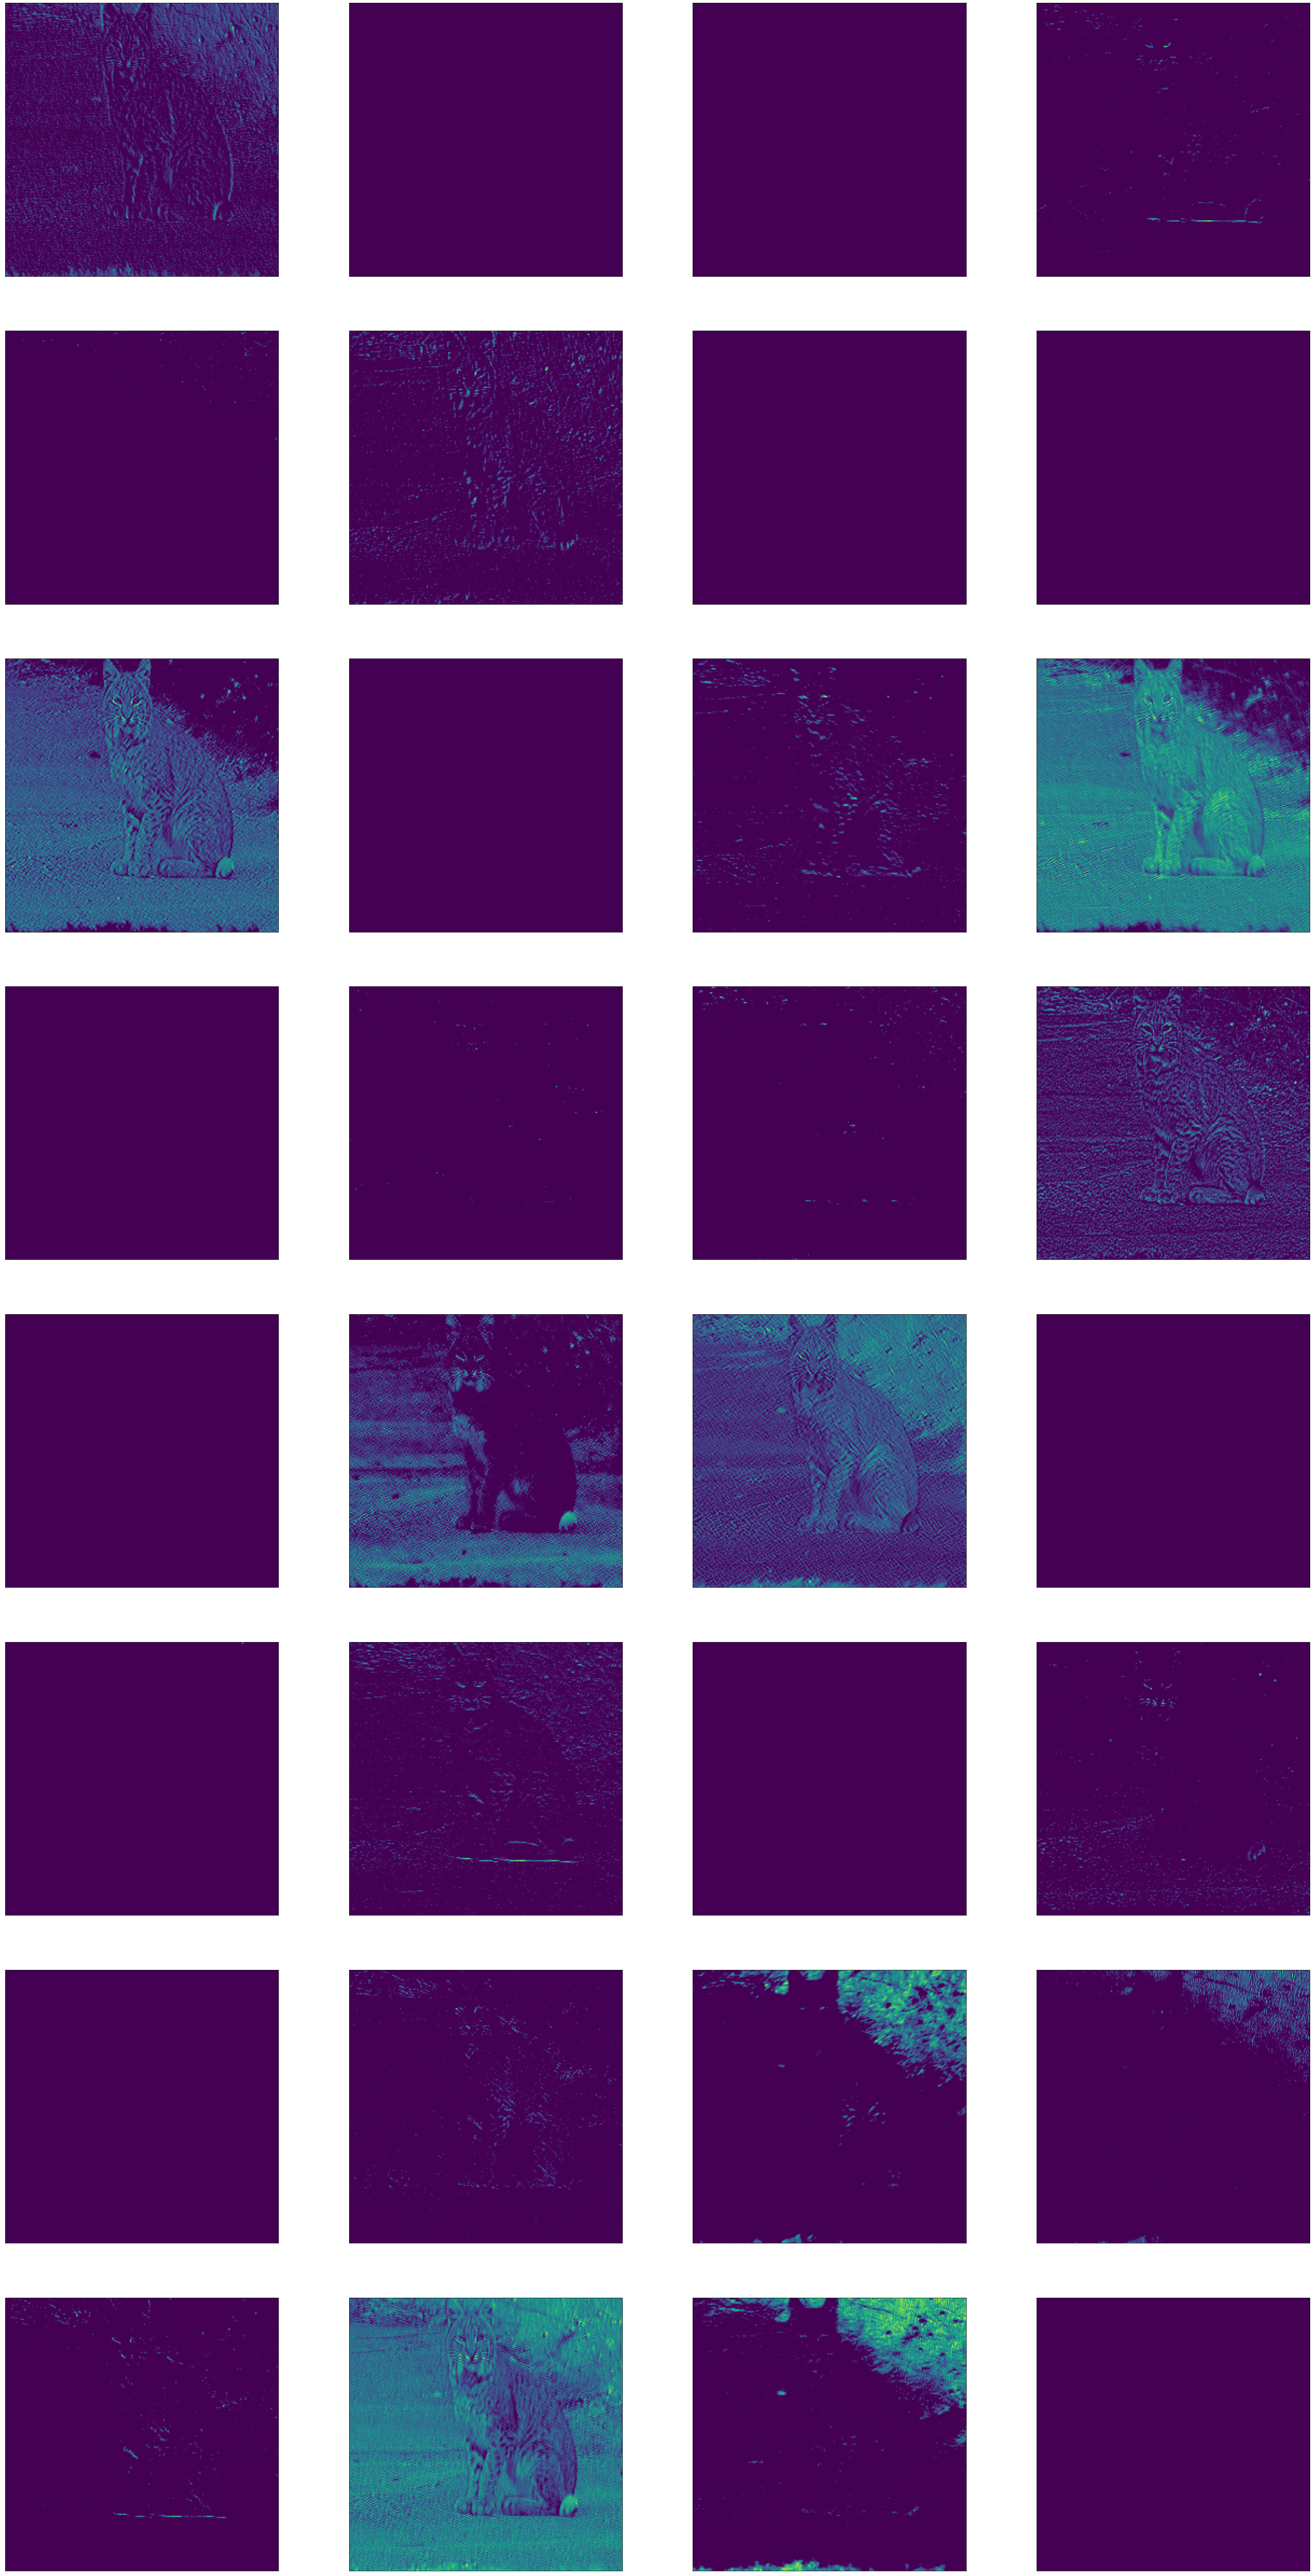

In [40]:
pyplot.figure(figsize=[50, 100])

for ii in range(8):
    for jj in range(4):
        ax = pyplot.subplot(8, 4, 4 * ii + jj + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(result[0, :, :, ii * 4 + jj])

wandb.init(project = 'cs6910-a2')
wandb.log({'Filters Visualization' : pyplot})